# Good Software - analysis notebook
## Reproducing all panels from Figure 1

<br />
This notebook contains all Python code necessary to reproduce all panels from the Figure 1 of [our paper](./), starting from the raw dataset. If you are interested in reproducing our results, you can use Binder to get started immediately (no requirements). For more information, visit [our wiki page](./).

**Github:** https://github.com/smangul1/good.software/wiki

**Manuscript:** https://www.biorxiv.org/content/early/2018/10/25/452532

**Twitter thread:** https://twitter.com/serghei_mangul/status/1055561147431043072

### Importing libraries

In [1]:
import pylab as pl
import numpy as np
import pandas as pd
import scikit_posthocs as sph

### Some definitions

In [2]:
# Legend for link statuses
legendStatus = { -1 : 'Time out', 1 : 'Accessible', 3 : 'Redirected', 4 : 'Broken' }

# Colors for each status
colors = { -1 : (0.96,0.65,0.51), 1 : (0.57,0.77,0.87), 3 : (0.02,0.44,0.69), 4 : (0.8,0.,0.13) }

# Scheme 2:
colors2 = { 'bg_unreach' : (1.0,0.8,0.6), 
            'fg_unreach' : (0.8,0.,0.), 
            'bg_accessb' : (0.7,1.0,0.7), 
            'fg_accessb' : (0.0,0.0,0.8)
         }

# Will only consider these years
initialYear = 2005

### Util functions

In [3]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Importing and parsing data

In [4]:
links = pd.read_csv('eval.links.bulk.csv')
links.head()

,type,journal,id,year,link,code,flag.uniqueness,newtest,oldcode,concated,httpsthing,github.com,0.690657769
0,body,BMC_Bioinformatics,15268767.0,2004,(http://discover.nci.nih.gov),-1,0,http,-1.0,15268767(http://discover.nci.nih.gov),0,False,NaN
1,body,BMC_Bioinformatics,15268767.0,2004,(http://dtp.nci.nih.gov),-1,0,http,-1.0,15268767(http://dtp.nci.nih.gov),0,False,NaN
2,body,Nucleic_Acids_Res,21398627.0,2011,(http://globin.cse.psu.edu/html/docs/sim4.html,-1,0,http,-1.0,21398627(http://globin.cse.psu.edu/html/docs/s...,0,False,NaN
3,body,BMC_Genomics,11472633.0,2001,(http://rgd.mcw.edu/RHMAPSERVER/),-1,0,http,-1.0,11472633(http://rgd.mcw.edu/RHMAPSERVER/),0,False,NaN
4,body,BMC_Bioinformatics,19426459.0,2009,(http://www.eumodic.org/documents/EMPReSSslim%...,-1,0,http,-1.0,19426459(http://www.eumodic.org/documents/EMPR...,0,False,NaN


In [5]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48392 entries, 0 to 48391
Data columns (total 13 columns):
type               48392 non-null object
journal            48392 non-null object
id                 48093 non-null float64
year               48392 non-null int64
link               48392 non-null object
code               48392 non-null int64
flag.uniqueness    48392 non-null int64
newtest            30019 non-null object
oldcode            30019 non-null float64
concated           48392 non-null object
httpsthing         48392 non-null int64
github.com         48392 non-null bool
0.690657769        0 non-null float64
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 4.5+ MB


Parsing from code into human-readable status:

* -1 : time out
* 0..299 : good
* 300..399 : redirected
* \>= 400 : not found

To make it easier, let's map these codes to -1 for time out, 1 for accessible, 3 for redirected, and 4 for not found.

In [6]:
links = links[ links.year >= initialYear ]
links['status'] = ( links['code'] // 100 )
links.loc[ links['status'] > 4, 'status' ] = 4
links.loc[ (links['status'] >= 0) & (links['status'] < 3), 'status' ] = 1

Let's look at the histogram of statuses

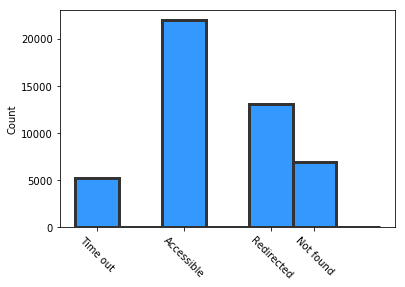

In [7]:
statuses = np.array( links.status )


f, ax = pl.subplots(1, 1)
ax.hist( statuses, np.arange(-1.5,6,1), edgecolor=(0.2,0.2,0.2), lw=3, 
            color=(0.2,0.6,1.0) )


ax.set_ylabel('Count')
ax.set_xticks([-1, 1, 3, 4])
ax.set_xticklabels( ['Time out', 'Accessible', 'Redirected', 'Not found'], rotation=-45 )

pl.show()

In [8]:
count, bin_values = np.histogram(statuses, bins = [-1.2,-0.8,1.8,3.8,4.8])

print(count, bin_values)
total = float(count.sum())

for j in range(4):
    print(count[j]/total)

[ 5259 21953 13106  6957] [-1.2 -0.8  1.8  3.8  4.8]
0.11124272871496563
0.46436805922792174
0.27722897937599156
0.1471602326811211


### Filtering out repeated links

To avoid using repeated links, let's create another dataframe.

In [9]:
uniqueLinks = links[ links['flag.uniqueness'] == 0 ]
print(uniqueLinks.shape)
uniqueLinks = uniqueLinks.drop(columns=['flag.uniqueness'])
uniqueLinks.head()

(36702, 14)


,type,journal,id,year,link,code,newtest,oldcode,concated,httpsthing,github.com,0.690657769,status
2,body,Nucleic_Acids_Res,21398627.0,2011,(http://globin.cse.psu.edu/html/docs/sim4.html,-1,http,-1.0,21398627(http://globin.cse.psu.edu/html/docs/s...,0,False,NaN,-1
4,body,BMC_Bioinformatics,19426459.0,2009,(http://www.eumodic.org/documents/EMPReSSslim%...,-1,http,-1.0,19426459(http://www.eumodic.org/documents/EMPR...,0,False,NaN,-1
5,body,BMC_Bioinformatics,16026597.0,2005,(http://www.fda.gov/cder/genomics/,-1,http,-1.0,16026597(http://www.fda.gov/cder/genomics/,0,False,NaN,-1
6,body,BMC_Bioinformatics,16026597.0,2005,(http://www.fda.gov/oc/initiatives/criticalpath/,-1,http,-1.0,16026597(http://www.fda.gov/oc/initiatives/cri...,0,False,NaN,-1
7,body,PLoS_Comput_Biol,22022247.0,2011,(http://www.ks.uiuc.edu/Development/MDTools/io...,-1,http,-1.0,22022247(http://www.ks.uiuc.edu/Development/MD...,0,False,NaN,-1


In [10]:
repeated_data = pd.concat(g for _, g in uniqueLinks.groupby("id") if len(g) > 1)
repeated_data.head(15)

,type,journal,id,year,link,code,newtest,oldcode,concated,httpsthing,github.com,0.690657769,status
6387,body,Nucleic_Acids_Res,15608157.0,2005,www.human-siRNA-database.net,301,http,-1.0,15608157www.human-siRNA-database.net,0,False,NaN,3
22888,abstract,Nucleic_Acids_Res,15608157.0,2005,http://www.human-siRNA-database.net,404,http,301.0,15608157http://www.human-siRNA-database.net,0,False,NaN,4
1890,body,Nucleic_Acids_Res,15608160.0,2005,http://infernal.wustl.edu/,-1,http,-1.0,15608160http://infernal.wustl.edu/,0,False,NaN,-1
2814,abstract,Nucleic_Acids_Res,15608160.0,2005,http://rfam.wustl.edu/,-1,http,-1.0,15608160http://rfam.wustl.edu/,0,False,NaN,-1
17798,abstract,Nucleic_Acids_Res,15608160.0,2005,http://www.sanger.ac.uk/Software/Rfam/,301,http,301.0,15608160http://www.sanger.ac.uk/Software/Rfam/,0,False,NaN,3
341,body,Nucleic_Acids_Res,15608162.0,2005,http://aosearch.cgb.ki.se,-1,http,-1.0,15608162http://aosearch.cgb.ki.se,0,False,NaN,-1
23661,abstract,Nucleic_Acids_Res,15608162.0,2005,http://siRNA.cgb.ki.se,503,http,301.0,15608162http://siRNA.cgb.ki.se,0,False,NaN,4
307,abstract,Nucleic_Acids_Res,15608164.0,2005,http://alpha.protres.ru/trnadbase,-1,http,-1.0,15608164http://alpha.protres.ru/trnadbase,0,False,NaN,-1
43622,abstract,Nucleic_Acids_Res,15608164.0,2005,http://www.tRNA.uni-bayreuth.de,200,NaN,NaN,15608164http://www.tRNA.uni-bayreuth.de,0,False,NaN,1
12125,body,Nucleic_Acids_Res,15608166.0,2005,http://redpoll.pharmacy.ualberta.ca/CCDB,301,http,301.0,15608166http://redpoll.pharmacy.ualberta.ca/CCDB,0,False,NaN,3


In [11]:
uniqueLinks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36702 entries, 2 to 48391
Data columns (total 13 columns):
type           36702 non-null object
journal        36702 non-null object
id             36536 non-null float64
year           36702 non-null int64
link           36702 non-null object
code           36702 non-null int64
newtest        22872 non-null object
oldcode        22872 non-null float64
concated       36702 non-null object
httpsthing     36702 non-null int64
github.com     36702 non-null bool
0.690657769    0 non-null float64
status         36702 non-null int64
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 3.7+ MB


In [12]:
uniqueLinks.describe()

,id,year,code,oldcode,httpsthing,0.690657769,status
count,3.653600e+04,36702.000000,36702.000000,22872.000000,36702.000000,0.0,36702.000000
mean,2.282358e+07,2012.014332,237.005531,222.919902,0.137813,NaN,1.772628
std,3.722272e+06,3.483438,116.124262,134.608017,0.345182,NaN,1.541269
min,1.560816e+07,2005.000000,-1.000000,-1.000000,0.000000,NaN,-1.000000
25%,1.978383e+07,2009.000000,200.000000,-1.000000,0.000000,NaN,1.000000
50%,2.318078e+07,2012.000000,200.000000,301.000000,0.000000,NaN,1.000000
75%,2.595065e+07,2015.000000,301.000000,301.000000,0.000000,NaN,3.000000
max,2.916934e+07,2017.000000,999.000000,405.000000,2.000000,NaN,4.000000


In [13]:
print( 'Percent of repeated links: %.1f%%' % ( (1 - len(uniqueLinks)/len(links))*100. ) )

Percent of repeated links: 22.4%


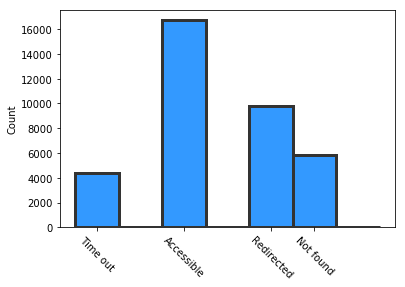

In [14]:
statuses = np.array( uniqueLinks.status )

f, ax = pl.subplots(1, 1)
ax.hist( statuses, np.arange(-1.5,6,1), edgecolor=(0.2,0.2,0.2), lw=3, 
            color=(0.2,0.6,1.0) )


ax.set_ylabel('Count')
ax.set_xticks([-1, 1, 3, 4])
ax.set_xticklabels( ['Time out', 'Accessible', 'Redirected', 'Not found'], rotation=-45 )

pl.show()

In [15]:
np.unique(uniqueLinks.id).shape

(19209,)

## Fixing http -> https redirection

Due to increased security awareness in the past few years, a number of links marked as redirections are in fact just changing the http protocol to https. We will not consider them as redirection, if the rest of the URL is the same.

In [16]:
# redirection_checking = pd.read_csv('http2https.redirected.csv', 
#                                     header=None, names=['pubmed_id', 'url', 'status', 'https_redirect']
#                                   )
# redirection_checking.head(10)

In [17]:
# for index, row in redirection_checking.iterrows():
#     if row['https_redirect'] == 'True' and uniqueLinks[ uniqueLinks.link == row['url']].shape[0] > 0:
#         idx = np.where(uniqueLinks.link == row['url'])[0][0]
#         uniqueLinks.iloc[idx,6] = 1

In [18]:
uniqueLinks.head()

,type,journal,id,year,link,code,newtest,oldcode,concated,httpsthing,github.com,0.690657769,status
2,body,Nucleic_Acids_Res,21398627.0,2011,(http://globin.cse.psu.edu/html/docs/sim4.html,-1,http,-1.0,21398627(http://globin.cse.psu.edu/html/docs/s...,0,False,NaN,-1
4,body,BMC_Bioinformatics,19426459.0,2009,(http://www.eumodic.org/documents/EMPReSSslim%...,-1,http,-1.0,19426459(http://www.eumodic.org/documents/EMPR...,0,False,NaN,-1
5,body,BMC_Bioinformatics,16026597.0,2005,(http://www.fda.gov/cder/genomics/,-1,http,-1.0,16026597(http://www.fda.gov/cder/genomics/,0,False,NaN,-1
6,body,BMC_Bioinformatics,16026597.0,2005,(http://www.fda.gov/oc/initiatives/criticalpath/,-1,http,-1.0,16026597(http://www.fda.gov/oc/initiatives/cri...,0,False,NaN,-1
7,body,PLoS_Comput_Biol,22022247.0,2011,(http://www.ks.uiuc.edu/Development/MDTools/io...,-1,http,-1.0,22022247(http://www.ks.uiuc.edu/Development/MD...,0,False,NaN,-1


In [19]:
statuses = uniqueLinks.status
count, bin_values = np.histogram(statuses, bins = [-1.2,-0.8,1.8,3.8,4.8])

print(count, bin_values)
total = float(count.sum())

for j in range(4):
    print(count[j]/total)

[ 4360 16720  9789  5833] [-1.2 -0.8  1.8  3.8  4.8]
0.11879461609721541
0.45556100484987194
0.26671571031551417
0.1589286687373985


In [20]:
(count[0]+count[-1])/total

0.2777232848346139

## Constructing a dataframe with only abstracts

In [21]:
uniqueLinks_abs = uniqueLinks[ uniqueLinks.type == 'abstract' ]
uniqueLinks_abs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7183 entries, 22 to 48382
Data columns (total 13 columns):
type           7183 non-null object
journal        7183 non-null object
id             7182 non-null float64
year           7183 non-null int64
link           7183 non-null object
code           7183 non-null int64
newtest        4185 non-null object
oldcode        4185 non-null float64
concated       7183 non-null object
httpsthing     7183 non-null int64
github.com     7183 non-null bool
0.690657769    0 non-null float64
status         7183 non-null int64
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 736.5+ KB


## Number of entries per journal

Next, let's evaluate the number of entries detected per journal.

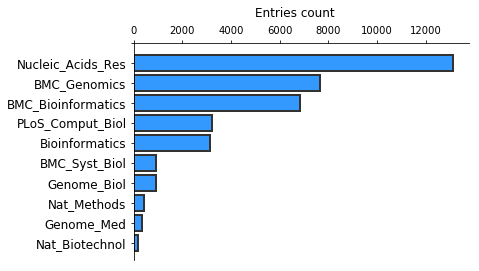

Journal name 		 Count
Nat_Biotechnol		 180
Genome_Med		 352
Nat_Methods		 403
Genome_Biol		 904
BMC_Syst_Biol		 912
Bioinformatics		 3131
PLoS_Comput_Bio		 3226
BMC_Bioinformat		 6840
BMC_Genomics		 7651
Nucleic_Acids_R		 13103


In [22]:
journals = np.array( uniqueLinks.journal )
journalTitles = np.unique(journals)

jhash = {}
for jid,journal in enumerate(journalTitles):
    jhash[journal] = jid
listxs = np.arange(0,11,1)

journals_num = [ jhash[journal] for journal in journals ]

counts, bins = np.histogram( journals_num, bins=listxs )

newIDX = np.argsort(counts)

f, ax = pl.subplots(1, 1)
ax.barh( bins[0:-1], counts[newIDX], 0.8, edgecolor=(0.2,0.2,0.2), lw=2, 
            color=(0.2,0.6,1.0) )

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_top()
ax.get_yaxis().tick_left()

ax.text( 5000, 11.3, 'Entries count', fontsize=12 )

ax.set_yticks( listxs )
ax.set_yticklabels( journalTitles[newIDX], rotation=0, fontsize=12 )

pl.show()

print('Journal name \t\t Count')
for jid,journal in enumerate(journalTitles[newIDX]):
    print('%s\t\t %d' %(journal[:15],counts[newIDX][jid]) )

Let's also detect how many of them were usable (i.e. accessible or redirected).

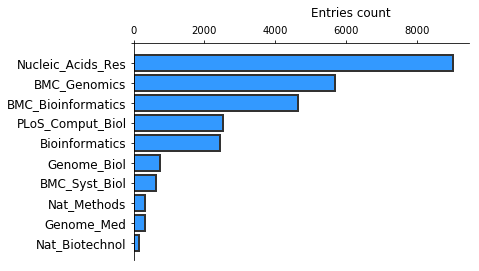

Journal name 		 Count
Nat_Biotechnol		 149
Genome_Med		 312
Nat_Methods		 326
BMC_Syst_Biol		 638
Genome_Biol		 746
Bioinformatics		 2448
PLoS_Comput_Bio		 2529
BMC_Bioinformat		 4651
BMC_Genomics		 5699
Nucleic_Acids_R		 9011


In [23]:
usable_links = uniqueLinks[(uniqueLinks.status == 1) | (uniqueLinks.status == 3)]
journals = np.array( usable_links.journal )
journalTitles = np.unique(journals)

jhash = {}
for jid,journal in enumerate(journalTitles):
    jhash[journal] = jid
listxs = np.arange(0,11,1)

journals_num = [ jhash[journal] for journal in journals ]

counts, bins = np.histogram( journals_num, bins=listxs )

newIDX = np.argsort(counts)

f, ax = pl.subplots(1, 1)
ax.barh( bins[0:-1], counts[newIDX], 0.8, edgecolor=(0.2,0.2,0.2), lw=2, 
            color=(0.2,0.6,1.0) )

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_top()
ax.get_yaxis().tick_left()

ax.text( 5000, 11.3, 'Entries count', fontsize=12 )

ax.set_yticks( listxs )
ax.set_yticklabels( journalTitles[newIDX], rotation=0, fontsize=12 )

pl.show()

print('Journal name \t\t Count')
for jid,journal in enumerate(journalTitles[newIDX]):
    print('%s\t\t %d' %(journal[:15],counts[newIDX][jid]) )

## Number of entries per abstract

Same for the number of abstracts

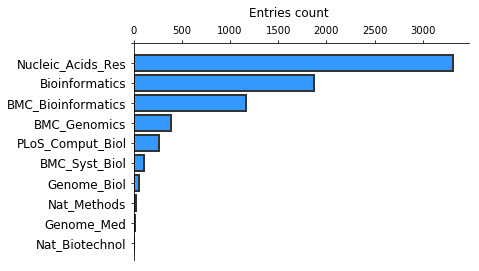

Journal name 		 Count
Nat_Biotechnol		 1
Genome_Med		 18
Nat_Methods		 20
Genome_Biol		 60
BMC_Syst_Biol		 104
PLoS_Comput_Bio		 259
BMC_Genomics		 386
BMC_Bioinformat		 1161
Bioinformatics		 1866
Nucleic_Acids_R		 3308


In [24]:
journals = np.array( uniqueLinks_abs.journal )
journalTitles = np.unique(journals)

jhash = {}
for jid,journal in enumerate(journalTitles):
    jhash[journal] = jid
listxs = np.arange(0,11,1)

journals_num = [ jhash[journal] for journal in journals ]

counts, bins = np.histogram( journals_num, bins=listxs )

newIDX = np.argsort(counts)

f, ax = pl.subplots(1, 1)
ax.barh( bins[0:-1], counts[newIDX], 0.8, edgecolor=(0.2,0.2,0.2), lw=2, 
            color=(0.2,0.6,1.0) )

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_top()
ax.get_yaxis().tick_left()

ax.text( 1200, 11.3, 'Entries count', fontsize=12 )

ax.set_yticks( listxs )
ax.set_yticklabels( journalTitles[newIDX], rotation=0, fontsize=12 )

pl.show()

print('Journal name \t\t Count')
for jid,journal in enumerate(journalTitles[newIDX]):
    print('%s\t\t %d' %(journal[:15],counts[newIDX][jid]) )

## Number of of links per year

In [25]:
uLinks_year = uniqueLinks.groupby(['year', 'status']).agg('count')

In [26]:
uLinks_year.head(12)

type  journal   id  link  code  newtest  oldcode  concated  \
year status                                                               
2005 -1       421      421  419   421   421      421      421       421   
      1       400      400  399   400   400       82       82       400   
      3       316      316  315   316   316      316      316       316   
      4       428      428  414   428   428      194      194       428   
2006 -1       375      375  366   375   375      375      375       375   
      1       424      424  424   424   424       94       94       424   
      3       399      399  398   399   399      399      399       399   
      4       384      384  377   384   384      169      169       384   
2007 -1       360      360  358   360   360      360      360       360   
      1       435      435  430   435   435       97       97       435   
      3       441      441  427   441   441      441      441       441   
      4       405      405  404   405   405      177      177       405   

             httpsthing  github.com  0.690657769  
year status                                       
2005 -1             421         421            0  
      1             400         400            0  
      3             316         316            0  
      4             428         428            0  
2006 -1             375         375            0  
      1             424         424            0  
      3             399         399            0  
      4             384         384            0  
2007 -1             360         360            0  
      1             435         435            0  
      3             441         441            0  
      4             405         405            0

Grouping by status and retrieving the percent for each status per year.

In [27]:
tseries = {}
for j,status in enumerate([-1, 1, 3, 4]):
    tseries[status] = np.array( uLinks_year.iloc[j::4].link )

Plotting

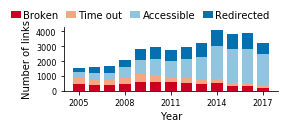

In [28]:
barsize=0.75

f, ax = pl.subplots(1, 1, figsize=(4,2.2) )

b = np.zeros( tseries[status].shape[0] )
years = np.arange(2005,2018,1)

for zlabel,status in enumerate([4,-1,1,3]):
    ax.bar( years, tseries[status] + b, barsize, label=legendStatus[status], 
               color=colors[status], zorder=-1-zlabel )
    b += tseries[status]

simpleaxis(ax)

ax.set_ylabel("Number of links")
ax.set_yticks( np.arange(0,4001,1000) )
ax.set_yticklabels( np.array( np.arange(0,4001,1000), dtype=int ), fontsize=8 )

ax.set_xlabel("Year")
ax.set_xticks( np.arange( 2005,2020,3 ) )
ax.set_xticklabels( np.arange( 2005,2020,3 ), fontsize=8 )

pl.legend(bbox_to_anchor=(1,1.4), frameon=False, ncol=4, 
          handletextpad=0.2, columnspacing=0.8, handlelength=1)

pl.tight_layout()
pl.savefig('NumLinks per year - all.pdf')

## Percent of links per year

Normalizing the number of links for each year.

In [29]:
tseries_norm = np.zeros( tseries[-1].shape )
for status in [-1, 1, 3, 4]:
    tseries_norm += tseries[status]

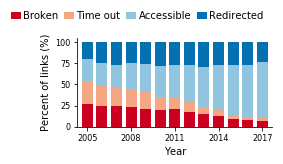

In [30]:
barsize=0.75

f, ax = pl.subplots(1, 1, figsize=(3.8,2.7) )

b = np.zeros( tseries[status].shape[0] )
years = np.arange(2005,2018,1)

for zlabel,status in enumerate([4,-1,1,3]):
    ax.bar( years, ( tseries[status]/tseries_norm + b )*100., 
               barsize, label=legendStatus[status], 
               color=colors[status], zorder=-1-zlabel )
    b += tseries[status]/tseries_norm

simpleaxis(ax)

ax.set_ylabel("Percent of links (%)")
ax.set_yticks( np.arange(0,101,25) )
ax.set_yticklabels( np.array( np.arange(0,101,25), dtype=int ), fontsize=8 )

ax.set_xlabel("Year")
ax.set_xlim(2004.3, 2017.7)
ax.set_xticks( np.arange( 2005,2018,3 ) )
ax.set_xticklabels( np.arange( 2005,2020,3 ), fontsize=8 )

pl.legend(bbox_to_anchor=(1,1.4), frameon=False, ncol=4, 
          handletextpad=0.2, columnspacing=0.6, handlelength=1)

pl.tight_layout()
pl.savefig('1a.pdf',bbox_inches = "tight")

## Number of links as function of time

Counting total number per year

Plotting:

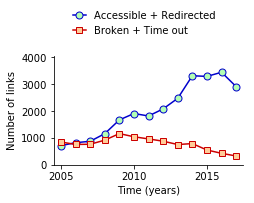

In [31]:
f, ax = pl.subplots( 1, 1, figsize=(3.4, 2.) )

pl.plot( years, tseries[1] + tseries[3], 'o-', 
            markersize=7, label='Accessible + Redirected', color=colors2['fg_accessb'],
            markeredgecolor=colors2['fg_accessb'], markerfacecolor=colors2['bg_accessb'] )
pl.plot( years, tseries[-1] + tseries[4], 's-', 
            markersize=6, label='Broken + Time out', color=colors2['fg_unreach'],
            markeredgecolor=colors2['fg_unreach'], markerfacecolor=colors2['bg_unreach'] )

simpleaxis(ax)

pl.ylabel('Number of links')
pl.ylim(0,4050)

pl.xlabel('Time (years)')
pl.xlim(2004.5,2017.5)
pl.xticks([2005,2010,2015])

pl.legend(bbox_to_anchor=(0.9,1.5), frameon=False, handlelength=1.3)

pl.savefig('1b.pdf',bbox_inches = "tight")

Ratio between accessible links in 2017 in reference to that in 2005

In [32]:
numAccessible = tseries[1] + tseries[3]

ratio = numAccessible[-1] / numAccessible[0]
print('Ratio: %.2f' % ratio)

avgGrowthRatio = (numAccessible[-1] - numAccessible[0]) / (2017-2005) / numAccessible[0]
print( 'Average growth ratio: %.1f%%' % (avgGrowthRatio*100) )

Ratio: 4.07
Average growth ratio: 25.6%


Ratio between unreachable links in 2017 in reference to that in 2005

In [33]:
numUnreachable = tseries[-1] + tseries[4]

ratio = numUnreachable[-1] / numUnreachable[0]
print('Ratio: %.2f' % ratio)


avgGrowthRatio = (numUnreachable[-1] - numUnreachable[0]) / (2017-2005) / numUnreachable[0]
print( 'Average growth ratio: %.1f%%' % (avgGrowthRatio*100) )

Ratio: 0.39
Average growth ratio: -5.1%


# Parsing Github and SourceForge

In [34]:
def count_status(statuses):
    count, bin_values = np.histogram(statuses, bins = [-1.2,-0.8,1.8,3.8,4.8])

    print(count, bin_values)
    total = float(count.sum())

    for j in range(4):
        print(count[j]/total)

In [35]:
find_github = lambda x: 'github.com' in x.link
find_sourceforge = lambda x: ('sourceforge.net' in x.link) or ('.sf.net' in x.link)
find_others = lambda x: ('github.com' not in x.link) and ('sourceforge.net' not in x.link) and ('.sf.net' not in x.link)

# uniqLabs_github = uniqueLinks_abs[ uniqueLinks_abs.apply(find_github, axis=1) ]
# uniqLabs_sourceforge = uniqueLinks_abs[ uniqueLinks_abs.apply(find_sourceforge, axis=1) ]
# uniqLabs_others = uniqueLinks_abs[ uniqueLinks_abs.apply(find_others, axis=1) ]

uniqLabs_github = uniqueLinks[ uniqueLinks.apply(find_github, axis=1) ]
uniqLabs_sourceforge = uniqueLinks[ uniqueLinks.apply(find_sourceforge, axis=1) ]
uniqLabs_others = uniqueLinks[ uniqueLinks.apply(find_others, axis=1) ]

count_status(uniqLabs_github.status)
count_status(uniqLabs_sourceforge.status)
count_status(uniqLabs_others.status)

[   0 1553  188   43] [-1.2 -0.8  1.8  3.8  4.8]
0.0
0.8705156950672646
0.10538116591928251
0.024103139013452915
[  5 608 315  64] [-1.2 -0.8  1.8  3.8  4.8]
0.005040322580645161
0.6129032258064516
0.3175403225806452
0.06451612903225806
[ 4355 14559  9286  5726] [-1.2 -0.8  1.8  3.8  4.8]
0.12836762365147675
0.42913989270765784
0.27371337617166774
0.16877910746919766


In [36]:
import scipy.stats as statsrich
oddsratio, pvalue = statsrich.fisher_exact([[(3+86),(138)], [(1050+2521), (2135+897)]])
print(oddsratio)

0.5475833911663602


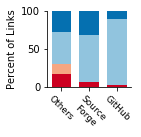

In [37]:
f, ax = pl.subplots( 1, 1, figsize=(1.5, 1.4) )

# let's make sure the order is maintained:
data_broken = np.array([0.16877910746919766, 0.06451612903225806, 0.024103139013452915])
data_timeout = np.array([0.12836762365147675, 0.005040322580645161, 0])
data_accessible = np.array([0.42913989270765784, 0.6129032258064516, 0.8705156950672646])
data_redirected = np.array([0.27371337617166774, 0.3175403225806452, 0.10538116591928251])

pl.bar( [0,1,2], 100*(data_broken+data_timeout+data_accessible+data_redirected), 0.7, color=colors[3], lw=1.3, capsize=8 )
pl.bar( [0,1,2], 100*(data_broken+data_timeout+data_accessible), 0.7, color=colors[1], lw=1.3, capsize=8 )
pl.bar( [0,1,2], 100*(data_broken+data_timeout), 0.7, color=colors[-1], lw=1.3, capsize=8 )
pl.bar( [0,1,2], 100*(data_broken), 0.7, color=colors[4], lw=1.3, capsize=8 )

ax.set_ylim(0,100)
ax.set_ylabel('Percent of Links')

ax.set_xlabel('')
ax.set_xlim(-0.5,2.5)
ax.set_xticks([0,1,2])
ax.set_xticklabels( ['Others','Source\nForge','GitHub'], 
                       rotation=-45, fontsize=9)

simpleaxis(ax)

pl.savefig('1f.pdf',bbox_inches = "tight")

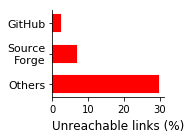

In [38]:
f, ax = pl.subplots(1, 1, figsize=(2.,1.6))

data_broken = np.array([0.16877910746919766, 0.06451612903225806, 0.024103139013452915])*100
data_timeout = np.array([0.12836762365147675, 0.005040322580645161, 0])*100

data_unreachable = data_broken + data_timeout

ax.barh( [0,1,2], data_unreachable, 0.6, edgecolor=(1.0,0.0,0.0), lw=0.1, color=(1.0,0.0,0.0) )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.text( -0.05, -1.5, 'Unreachable links (%)', fontsize=12 )

ax.set_xticks( [0, 10, 20, 30] )
ax.set_yticks( [0, 1, 2] )
ax.set_yticklabels( ['Others', 'Source\nForge', 'GitHub'], rotation=0, fontsize=11 )

pl.savefig('1h.pdf',bbox_inches = "tight")

norm
year
2005    1565
2006    1582
2007    1641
2008    2079
2009    2835
2010    2954
2011    2783
2012    2962
2013    3232
2014    4108
2015    3844
2016    3875
2017    3242
Name: type, dtype: int64
github
year
2009     0.070547
2010     0.507786
2011     0.682716
2012     1.553005
2013     2.753713
2014     5.209348
2015     9.469303
2016    13.006452
Name: type, dtype: float64
sf
year
2005    1.022364
2006    2.085967
2007    2.071907
2008    2.308802
2009    2.574956
2010    3.588355
2011    3.377650
2012    4.287643
2013    2.629950
2014    3.042843
2015    2.523413
2016    2.606452
2017    1.634793
Name: type, dtype: float64


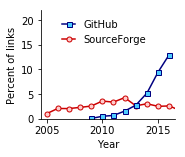

In [39]:
tseries_norm = uniqueLinks.groupby(['year']).agg('count').type
tseries_GH = uniqLabs_github.groupby(['year']).agg('count').type[:-1]/tseries_norm[4:-1]*100
years_gh = range(2009,2017)
tseries_SF = uniqLabs_sourceforge.groupby(['year']).agg('count').type/tseries_norm[:]*100
years_sf = range(2005,2018)

print("norm")
print(tseries_norm)
print("github")
print(tseries_GH)
print("sf")
print(tseries_SF)

f, ax = pl.subplots( 1, 1, figsize=(2.4, 2.) )


gh_color=(0.0,0.0,0.5)
gh_incolor=(0.3,0.8,1.0)
pl.plot( years_gh, tseries_GH, 's-', zorder=2,
            markersize=5, label='GitHub', color=gh_color,
            markeredgecolor=gh_color, markerfacecolor=gh_incolor )

sf_color=(0.8,0.0,0.0)
sf_incolor=(1.0,0.8,0.8)
pl.plot( years_sf, tseries_SF, 'o-', zorder=1,
            markersize=5, label='SourceForge', color=sf_color,
            markeredgecolor=sf_color, markerfacecolor=sf_incolor )

simpleaxis(ax)

pl.ylabel('Percent of links')
pl.ylim(0,22)
ax.set_xticks([2005, 2010, 2015])

pl.xlabel('Year')
pl.xlim(2004.5,2016.5)

pl.legend(bbox_to_anchor=(0.85,1.), frameon=False, handlelength=1.3, fontsize=10)

pl.savefig('1g.pdf',bbox_inches = "tight")

## Number of links per year - abstract only

In [40]:
uLinks_ya = uniqueLinks_abs.groupby(['year', 'status']).agg('count')

tseries_abs = {}
for j,status in enumerate([-1, 1, 3, 4]):
    tseries_abs[status] = np.array( uLinks_ya.iloc[j::4].link )

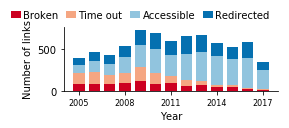

In [41]:
barsize=0.75

f, ax = pl.subplots(1, 1, figsize=(4,2.2) )

b = np.zeros( tseries_abs[status].shape[0] )
years = np.arange(2005,2018,1)

for zlabel,status in enumerate([4,-1,1,3]):
    ax.bar( years, tseries_abs[status] + b, barsize, label=legendStatus[status], 
               color=colors[status], zorder=-1-zlabel )
    b += tseries_abs[status]

simpleaxis(ax)

ax.set_ylabel("Number of links")
#ax.set_yticks( np.arange(0,2001,500) )
#ax.set_yticklabels( np.array( np.arange(0,2001,500), dtype=int ), fontsize=8 )

ax.set_xlabel("Year")
ax.set_xticks( np.arange( 2005,2020,3 ) )
ax.set_xticklabels( np.arange( 2005,2020,3 ), fontsize=8 )

pl.legend(bbox_to_anchor=(1,1.4), frameon=False, ncol=4, 
          handletextpad=0.2, columnspacing=0.8, handlelength=1)

pl.tight_layout()
pl.savefig('NumLinks per year - Abstract.pdf')

In [42]:
tseries_norm = np.zeros( tseries_abs[-1].shape )
for status in [-1, 1, 3, 4]:
    tseries_norm += tseries_abs[status]

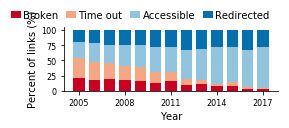

In [43]:
barsize=0.75

f, ax = pl.subplots(1, 1, figsize=(4,2.2) )

b = np.zeros( tseries_abs[status].shape[0] )
years = np.arange(2005,2018,1)

for zlabel,status in enumerate([4,-1,1,3]):
    ax.bar( years, 100*(tseries_abs[status] + b)/tseries_norm, barsize, 
               label=legendStatus[status], 
               color=colors[status], zorder=-1-zlabel )
    b += tseries_abs[status]

simpleaxis(ax)

ax.set_ylabel("Percent of links (%)")
ax.set_yticks( np.arange(0,101,25) )
ax.set_yticklabels( np.array( np.arange(0,101,25), dtype=int ), fontsize=8 )

ax.set_xlabel("Year")
ax.set_xticks( np.arange( 2005,2020,3 ) )
ax.set_xticklabels( np.arange( 2005,2020,3 ), fontsize=8 )

pl.legend(bbox_to_anchor=(1,1.4), frameon=False, ncol=4, 
          handletextpad=0.2, columnspacing=0.8, handlelength=1)

pl.tight_layout()
pl.savefig('Percent per year - Abstract.pdf')

## Status vs IF of current journal 

List of journals considered in this study:

In [44]:
journals = uniqueLinks.journal.unique()
print( journals )

['Nucleic_Acids_Res' 'BMC_Bioinformatics' 'PLoS_Comput_Biol'
 'BMC_Genomics' 'Bioinformatics' 'Nat_Methods' 'Genome_Biol'
 'BMC_Syst_Biol' 'Nat_Biotechnol' 'Genome_Med']


Impact factors were retrieved from this address: http://admin-apps.webofknowledge.com/JCR/JCR?RQ=HOME

In [45]:
IFdata = pd.read_csv('impact_factors_timeseries.csv')
IFdata = IFdata.fillna(0)
IFdata

,year,BMC_Genomics,Nucleic_Acids_Res,Bioinformatics,BMC_Bioinformatics,PLoS_Comput_Biol,Genome_Biol,BMC_Syst_Biol,Nat_Biotechnol,Nat_Methods,Genome_Med
0,2016,3.729,10.162,7.307,2.448,4.542,11.908,2.303,41.667,25.062,7.071
1,2015,3.867,9.202,5.766,2.435,4.587,11.313,2.208,43.113,25.328,5.846
2,2014,3.986,9.112,4.981,2.576,4.620,10.810,2.435,41.514,32.072,5.809
3,2013,4.041,8.808,4.621,2.672,4.829,10.465,2.853,39.080,25.953,4.942
4,2012,4.397,8.278,5.323,3.024,4.867,10.288,2.982,32.438,23.565,3.906
5,2011,4.073,8.026,5.468,2.751,5.215,9.036,3.148,23.268,19.276,0.000
6,2010,4.206,7.836,4.877,3.029,5.515,6.885,3.565,31.090,20.721,0.000
7,2009,3.759,7.479,4.926,3.428,5.759,6.626,4.064,29.495,16.874,0.000
8,2008,3.926,6.878,4.328,3.781,5.895,6.153,3.706,22.297,13.651,0.000
9,2007,4.180,6.954,5.039,3.493,6.236,6.589,0.000,22.848,15.478,0.000


In [46]:
count = {}
Z = np.zeros( (10) )
for status in [1,3,-1,4]:
    count[status] = np.zeros( (10) )

def journalID(journalName): 
    if journalName in journals:
        return np.argwhere(journals == journalName)[0][0]
    else: return -1

for index, row in uniqueLinks.iterrows():
    jid = journalID(row.journal)
    if jid != -1:
        count[row['status']][ jid ] += 1
        Z[ jid ] += 1
    

# Normalizing
for status in [1,3,-1,4]:
    count[status] /= Z

In [47]:
IFs = np.array( IFdata.iloc[0] )[1:]
newIDX = np.argsort( IFs )
IFs = IFs[newIDX]

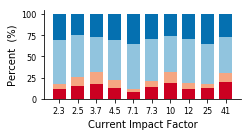

In [48]:
barsize=0.7

f, ax = pl.subplots(1, 1, figsize=(3.6,2.0) )

IFs_x = np.arange(10)

ax.bar( IFs_x, count[4][newIDX], barsize, label='Broken', 
           color=colors[4], zorder=-1 )
b = np.copy( count[4][newIDX] )

ax.bar( IFs_x, b+count[-1][newIDX], barsize, label='Time out', 
           color=colors[-1], zorder=-2 )
b += count[-1][newIDX]

ax.bar( IFs_x, b+count[1][newIDX], barsize, label='Good', 
           color=colors[1], zorder=-3 )
b += count[1][newIDX]

ax.bar( IFs_x, b+count[3][newIDX], barsize, label='Redirect',
           color=colors[3], zorder=-4 )

simpleaxis(ax)

ax.set_ylabel("Percent  (%)")
ax.set_yticks( np.arange(0,1.1,0.25) )
ax.set_yticklabels( np.array( np.arange(0,1.1,0.25)*100, dtype=int ), fontsize=8 )

ax.set_xlabel("Current Impact Factor")
ax.set_xticks( IFs_x )
ax.set_xticklabels( ['2.3','2.5','3.7','4.5','7.1','7.3','10','12','25','41'], 
                       fontsize=8,  )

pl.tight_layout()
pl.savefig('Percent per IF.pdf')

## Status vs IF - abstracts only

List of journals considered in this study:

In [49]:
journals = uniqueLinks_abs.journal.unique()
print( journals )

['Bioinformatics' 'BMC_Bioinformatics' 'Nucleic_Acids_Res' 'BMC_Genomics'
 'BMC_Syst_Biol' 'PLoS_Comput_Biol' 'Genome_Med' 'Genome_Biol'
 'Nat_Methods' 'Nat_Biotechnol']


Impact factors were retrieved from this address: http://admin-apps.webofknowledge.com/JCR/JCR?RQ=HOME

In [50]:
count = {}
Z = np.zeros( (10) )
for status in [1,3,-1,4]:
    count[status] = np.zeros( (10) )

def journalID(journalName): 
    if journalName in journals:
        return np.argwhere(journals == journalName)[0][0]
    else: return -1

for index, row in uniqueLinks_abs.iterrows():
    jid = journalID(row.journal)
    if jid != -1:
        count[row['status']][ jid ] += 1
        Z[ jid ] += 1
    

# Normalizing
for status in [1,3,-1,4]:
    count[status] /= Z

In [51]:
IFs = np.array( IFdata.iloc[0] )[1:]
newIDX = np.argsort( IFs )
IFs = IFs[newIDX]

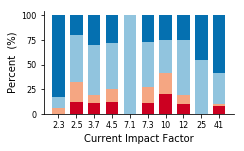

In [52]:
barsize=0.7

f, ax = pl.subplots(1, 1, figsize=(3.5,2.2) )

IFs_x = np.arange(10)

ax.bar( IFs_x, count[4][newIDX], barsize, label='Broken', 
           color=colors[4], zorder=-1 )
b = np.copy( count[4][newIDX] )

ax.bar( IFs_x, b+count[-1][newIDX], barsize, label='Time out', 
           color=colors[-1], zorder=-2 )
b += count[-1][newIDX]

ax.bar( IFs_x, b+count[1][newIDX], barsize, label='Good', 
           color=colors[1], zorder=-3 )
b += count[1][newIDX]

ax.bar( IFs_x, b+count[3][newIDX], barsize, label='Redirect',
           color=colors[3], zorder=-4 )

simpleaxis(ax)

ax.set_ylabel("Percent  (%)")
ax.set_yticks( np.arange(0,1.1,0.25) )
ax.set_yticklabels( np.array( np.arange(0,1.1,0.25)*100, dtype=int ), fontsize=8 )

ax.set_xlabel("Current Impact Factor")
ax.set_xticks( IFs_x )
ax.set_xticklabels( ['2.3','2.5','3.7','4.5','7.1','7.3','10','12','25','41'], 
                       fontsize=8,  )

pl.tight_layout()
pl.savefig('Percent per IF - abstracts.pdf')


## Status vs IF at the time of publication

In [53]:
IFpub = {}
for status in  [1,3,-1,4]:
    IFpub[status] = []

for index, row in uniqueLinks.iterrows():
    year = row.year
    if ( year >= 2003 ) and ( year <= 2017 ) :
        
        # there's no IF for 2017 yet
        if year == 2017: year = 2016
            
        yearIDX = -(year - 2003) + 13
        IF_at_time = IFdata[row.journal].iloc[ yearIDX ]
        IFpub[row.status].append( IF_at_time )

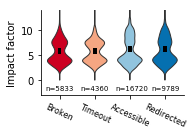

In [54]:
f, ax = pl.subplots( 1, 1, figsize=(2.8, 2.0) )

# let's make sure the order is maintained:
data = [IFpub[4], IFpub[-1], IFpub[1], IFpub[3]]

parts = ax.violinplot( data, [0,1,2,3], showmeans=False, showmedians=False, 
                              showextrema=False, widths=0.7, points=200 )
                          
colors_list = [colors[j] for j in [4, -1, 1, 3]]

j = 0
for pc in parts['bodies']:
    pc.set_facecolor(colors_list[j])
    pc.set_edgecolor( (0.2,0.2,0.2) )
    pc.set_edgecolors( (0.2,0.2,0.2) )
    pc.set_alpha(1)
    j += 1
    

def buttpos(x): return [x-0.05,x+0.05]
for j in range(4):
    pl.plot(buttpos(j), [np.mean(data[j])]*2, color="k", 
                linewidth=6, solid_capstyle="butt", zorder=4)

for j in range(4):
    ax.text( j-0.4, -2, 'n='+str(len(data[j])), fontsize=7 )

ax.set_ylim(-3,14)
ax.set_ylabel('Impact factor')

ax.set_xlabel('')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels( ['Broken','Timeout','Accessible','Redirected'], 
                       rotation=-25, fontsize=8 )
pl.tight_layout()
simpleaxis(ax)

pl.savefig('1c_old.pdf',bbox_inches = "tight")

In [55]:
from scipy import stats
f_value, p_value = stats.f_oneway(data[0], data[1], data[3], data[2])
print(f_value, p_value)

print(uniqueLinks_abs.groupby(['year']).agg('count'))

24.27790915038259 1.0928479654487711e-15
      type  journal   id  link  code  newtest  oldcode  concated  httpsthing  \
year                                                                           
2005   390      390  390   390   390      245      245       390         390   
2006   464      464  464   464   464      283      283       464         464   
2007   428      428  428   428   428      268      268       428         428   
2008   536      536  536   536   536      315      315       536         536   
2009   729      729  729   729   729      424      424       729         729   
2010   691      691  691   691   691      391      391       691         691   
2011   592      592  592   592   592      324      324       592         592   
2012   657      657  656   657   657      356      356       657         657   
2013   668      668  668   668   668      372      372       668         668   
2014   577      577  577   577   577      307      307       577         577   

## Evolution of IF of each category over the years

In [56]:
IFpub = {}
Z = {}
for status in  [1,3,-1,4]:
    IFpub[status] = np.zeros(12)
    Z[status] = np.zeros(12)

for index, row in uniqueLinks.iterrows():
    year = row.year
    if ( year >= 2003 ) and ( year <= 2017 ) :
        
        # there's no IF for 2017 yet
        if year == 2017: year = 2016
            
        yearIDX = year - 2005
        IF_at_time = IFdata[row.journal].iloc[ yearIDX ]
        IFpub[row.status][yearIDX] += IF_at_time
        Z[row.status][yearIDX] += 1

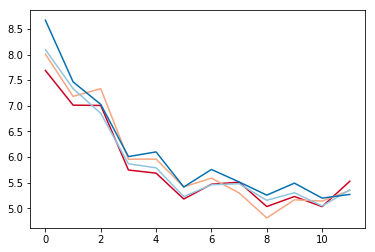

In [57]:
for s in [4,-1,1,3]:
    pl.plot( IFpub[s]/Z[s], color=colors[s] )

## Retrieving altmetric data

In [58]:
def parseAltmetricData(filename):

    parsedData = {}

    inputfile = open( filename, 'r' )

    # skipping first row
    inputfile.readline()

    for line in inputfile:

        lineSplit = line.split('\n')[0].split('[')

        ls_comma  = lineSplit[0].split(',')
        pmid      = int( ls_comma[0] )
        parsedData[pmid] = {}

        score     = float( ls_comma[1] )
        parsedData[pmid]['score'] = score

        numReaders = int( ls_comma[2] )
        parsedData[pmid]['numReaders'] = numReaders

        cited     = int( ls_comma[3] )
        parsedData[pmid]['cited'] = cited

        scopus = lineSplit[1][:-1]
        parsedData[pmid]['scopus'] = scopus

    return parsedData

dictAltmetric = parseAltmetricData('./links.bulk.altmetric.csv')

In [59]:
print( 'Number of Altmetric records: %d ' % (len(dictAltmetric.keys())) )

Number of Altmetric records: 13889 


In [60]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 3  # previous pdf hatch linewidth

## Altmetric score

In [61]:
scores = {}
for status in  [1,3,-1,4]:
    scores[status] = []

for index, row in uniqueLinks.iterrows():
    if row.id in dictAltmetric.keys():
        numYears = (2018 - year)
        scores[ row.status ].append( dictAltmetric[row.id]['score'] )

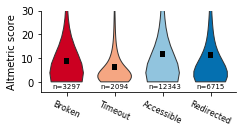

In [62]:
f, ax = pl.subplots( 1, 1, figsize=(3.5, 1.5) )

# let's make sure the order is maintained:
data = [scores[4], scores[-1], scores[1], scores[3]]

parts = ax.violinplot( data, [0,1,2,3], showmeans=False, showmedians=False, 
                              showextrema=False, widths=0.7, points=500 )

j = 0
for pc in parts['bodies']:
    pc.set_facecolor(colors_list[j])
    pc.set_edgecolor( (0.2,0.2,0.2) )
    pc.set_edgecolors( (0.2,0.2,0.2) )
    pc.set_alpha(1)
    j += 1
    

def buttpos(x): return [x-0.05,x+0.05]
for j in range(4):
    pl.plot(buttpos(j), [np.mean(data[j])]*2, color="k", 
                linewidth=6, solid_capstyle="butt", zorder=4)

for j in range(4):
    ax.text( j-0.3, -2.5, 'n='+str(len(data[j])), fontsize=7 )

ax.set_ylim(-4,30)
ax.set_ylabel('Altmetric score')

ax.set_xlabel('')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels( ['Broken','Timeout','Accessible','Redirected'], 
                       rotation=-25, fontsize=8)

simpleaxis(ax)

pl.savefig('Altmetric Score vs status.pdf')

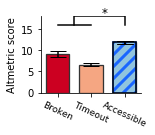

In [63]:
f, ax = pl.subplots( 1, 1, figsize=(1.8, 1.4) )

# let's make sure the order is maintained:
data = [ np.mean(scores[4]), np.mean(scores[-1]), np.mean(scores[1] + scores[3]) ]
vardata = [ np.std(scores[4])/np.sqrt(len(scores[4])), 
           np.std(scores[-1])/np.sqrt(len(scores[-1])), 
           np.std(scores[1] + scores[3])/np.sqrt(len(scores[1] + scores[3])) ]

pl.bar( [0,1,2], data, 0.7, yerr=vardata, color=colors_list, 
           edgecolor=[(0.2,0.2,0.2)]*3, lw=1.3, capsize=8 )

pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color=colors_list[2:], hatch="//",
           edgecolor=[(0.1,0.4,1.0)]*3, lw=1.5, capsize=8 )
pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color='none',
           edgecolor=[(0.0,0.0,0.0)]*3, lw=1.5, capsize=8 )

ax.set_ylabel('Altmetric score')
ax.set_ylim(0,18)
ax.set_yticks([0,5,10,15])

ax.set_xlabel('')
ax.set_xticks([0,1,2])
ax.set_xlim(-0.5,2.5)
ax.set_xticklabels( ['Broken','Timeout','Accessible'], 
                       rotation=-25, fontsize=9)

ax.text(1.3, 18, '*', fontsize=12)
ax.plot([2,2,0.5,0.5], [16,18,18,16], color='k', lw=1.5)
ax.plot([1,0], [16,16], color='k', lw=1.5)

simpleaxis(ax)

pl.savefig('1c.pdf',bbox_inches = "tight")

In [64]:
from scipy.stats.mstats import kruskalwallis
print(kruskalwallis(scores[-1],scores[4],scores[1],scores[3]))

lists = scores[-1]+scores[4]+scores[1]+scores[3]
categories = len(scores[-1])*[-1]+len(scores[4])*[4]+len(scores[1]+scores[3])*[1]

print(sph.posthoc_dunn([scores[-1],scores[4],(scores[1]+scores[3])], p_adjust='fdr_bh'))

KruskalResult(statistic=118.4228015588113, pvalue=1.6869222402985409e-25)
[[-1.00000000e+00  5.16142689e-02  2.47344772e-17]
 [ 5.16142689e-02 -1.00000000e+00  4.15518624e-14]
 [ 2.47344772e-17  4.15518624e-14 -1.00000000e+00]]


## Altmetric number of readers

In [65]:
scores = {}
for status in  [1,3,-1,4]:
    scores[status] = []

for index, row in uniqueLinks.iterrows():
    if row.id in dictAltmetric.keys():
        numYears = (2018 - year)
        scores[ row.status ].append( dictAltmetric[row.id]['numReaders'] / numYears )

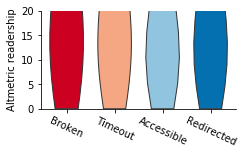

In [66]:
f, ax = pl.subplots( 1, 1, figsize=(3.5, 1.8) )

# let's make sure the order is maintained:
data = [scores[4], scores[-1], scores[1], scores[3]]

parts = ax.violinplot( data, [0,1,2,3], showmeans=True, showmedians=False, 
                              showextrema=False, widths=0.7, points=500 )

j = 0
for pc in parts['bodies']:
    pc.set_facecolor(colors_list[j])
    pc.set_edgecolor( (0.2,0.2,0.2) )
    pc.set_edgecolors( (0.2,0.2,0.2) )
    pc.set_alpha(1)
    j += 1
    

def buttpos(x): return [x-0.05,x+0.05]
for j in range(4):
    pl.plot(buttpos(j), [np.mean(data[j])]*2, color="k", 
                linewidth=6, solid_capstyle="butt", zorder=4)

# for j in range(4):
#     ax.text( j-0.4, -2, 'n='+str(len(data[j])), fontsize=7 )

ax.set_ylim(0,20)
ax.set_ylabel('Altmetric readership')

ax.set_xlabel('')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels( ['Broken','Timeout','Accessible','Redirected'], rotation=-25 )

simpleaxis(ax)

pl.savefig('Altmetric numReaders vs status.pdf')

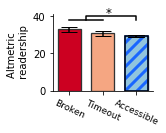

In [67]:
f, ax = pl.subplots( 1, 1, figsize=(1.8, 1.4) )

# let's make sure the order is maintained:
data = [ np.mean(scores[4]), np.mean(scores[-1]), np.mean(scores[1] + scores[3]) ]
vardata = [ np.std(scores[4])/np.sqrt(len(scores[4])), 
           np.std(scores[-1])/np.sqrt(len(scores[-1])), 
           np.std(scores[1] + scores[3])/np.sqrt(len(scores[1] + scores[3])) ]

colors=[(1.0,0.2,0.1),(1.0,0.6,0.2),(0.5,1.0,0.5)]
pl.bar( [0,1,2], data, 0.7, yerr=vardata, color=colors_list, 
           edgecolor=[(0.2,0.2,0.2)]*3, lw=1.3, capsize=8 )

pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color=colors_list[2:], hatch="//",
           edgecolor=[(0.1,0.4,1.0)]*3, lw=1.5, capsize=8 )
pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color='none',
           edgecolor=[(0.0,0.0,0.0)]*3, lw=1.5, capsize=8 )


ax.set_ylim(0,41)
ax.set_ylabel('Altmetric \n readership')

ax.set_xlabel('')
ax.set_xlim(-0.5,2.5)
ax.set_xticks([0,1,2])
ax.set_xticklabels( ['Broken','Timeout','Accessible'], 
                       rotation=-25, fontsize=9)

ax.text(1.1, 40, '*', fontsize=12)
ax.plot([2,2,0.5,0.5], [38,40,40,38], color='k', lw=1.5)
ax.plot([1,0], [38,38], color='k', lw=1.5)

simpleaxis(ax)

pl.savefig('1e.pdf',bbox_inches = "tight")

In [68]:
lists = scores[-1]+scores[4]+scores[1]+scores[3]
categories = len(scores[-1])*[-1]+len(scores[4])*[4]+len(scores[1]+scores[3])*[1]

print(sph.posthoc_dunn([scores[-1],scores[4],(scores[1]+scores[3])], p_adjust='fdr_bh'))

[[-1.00000000e+00  2.07209979e-01  1.16657681e-06]
 [ 2.07209979e-01 -1.00000000e+00  8.42073375e-15]
 [ 1.16657681e-06  8.42073375e-15 -1.00000000e+00]]


## Altmetric citation

In [69]:
scores = {}
for status in  [1,3,-1,4]:
    scores[status] = []

for index, row in uniqueLinks.iterrows():
    if row.id in dictAltmetric.keys():
        numYears = (2018 - year)
        scores[ row.status ].append( dictAltmetric[row.id]['cited'] / numYears )

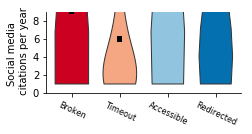

In [70]:
f, ax = pl.subplots( 1, 1, figsize=(3.5, 1.5) )

# let's make sure the order is maintained:
data = [scores[4], scores[-1], scores[1], scores[3]]

parts = ax.violinplot( data, [0,1,2,3], showmeans=False, showmedians=False, 
                              showextrema=False, widths=0.7, points=500 )

j = 0
for pc in parts['bodies']:
    pc.set_facecolor(colors_list[j])
    pc.set_edgecolor( (0.2,0.2,0.2) )
    pc.set_edgecolors( (0.2,0.2,0.2) )
    pc.set_alpha(1)
    j += 1
    

def buttpos(x): return [x-0.05,x+0.05]
for j in range(4):
    pl.plot(buttpos(j), [np.mean(data[j])]*2, color="k", 
                linewidth=6, solid_capstyle="butt", zorder=4)

# for j in range(4):
#     ax.text( j-0.4, -2, 'n='+str(len(data[j])), fontsize=7 )

ax.set_ylim(0,9)
ax.set_ylabel('Social media \n citations per year')
ax.set_yticks([0,2,4,6,8])

ax.set_xlabel('')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels( ['Broken','Timeout','Accessible','Redirected'], 
                       rotation=-25, fontsize=8 )

simpleaxis(ax)

pl.savefig('Altmetric Cited vs status.pdf')

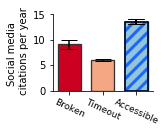

In [71]:
f, ax = pl.subplots( 1, 1, figsize=(1.8, 1.4) )

# let's make sure the order is maintained:
data = [ np.mean(scores[4]), np.mean(scores[-1]), np.mean(scores[1] + scores[3]) ]
vardata = [ np.std(scores[4])/np.sqrt(len(scores[4])), 
           np.std(scores[-1])/np.sqrt(len(scores[-1])), 
           np.std(scores[1] + scores[3])/np.sqrt(len(scores[1] + scores[3])) ]

colors=[(1.0,0.2,0.1),(1.0,0.6,0.2),(0.5,1.0,0.5)]
pl.bar( [0,1,2], data, 0.7, yerr=vardata, color=colors_list, 
           edgecolor=[(0.2,0.2,0.2)]*3, lw=1.3, capsize=8 )

pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color=colors_list[2:], hatch="//",
           edgecolor=[(0.1,0.4,1.0)]*3, lw=1.5, capsize=8 )
pl.bar( [2], data[2:], 0.7, yerr=vardata[2:], color='none',
           edgecolor=[(0.0,0.0,0.0)]*3, lw=1.5, capsize=8 )


ax.set_ylim(0,15)
ax.set_ylabel('Social media \n citations per year')

ax.set_xlabel('')
ax.set_xlim(-0.5,2.5)
ax.set_xticks([0,1,2])
ax.set_xticklabels( ['Broken','Timeout','Accessible'], 
                       rotation=-25, fontsize=9)


# ax.text(1.3, 4.7, '*', fontsize=12)
# ax.plot([2,2,0.5,0.5], [4,4.7,4.7,4], color='k', lw=1.5)
# ax.plot([0,1], [4,4], color='k', lw=1.5)
simpleaxis(ax)

pl.savefig('1d.pdf',bbox_inches = "tight")

In [72]:
lists = scores[-1]+scores[4]+scores[1]+scores[3]
categories = len(scores[-1])*[-1]+len(scores[4])*[4]+len(scores[1]+scores[3])*[1]

from scipy.stats.mstats import kruskalwallis
print(kruskalwallis(scores[-1],scores[4],scores[1],scores[3]))

print(sph.posthoc_dunn([scores[-1],scores[4],(scores[1]+scores[3])], p_adjust='fdr_bh'))


KruskalResult(statistic=746.4778493513235, pvalue=1.7515548139742244e-161)
[[-1.00000000e+000  1.22907386e-007  9.65803244e-103]
 [ 1.22907386e-007 -1.00000000e+000  3.37058804e-076]
 [ 9.65803244e-103  3.37058804e-076 -1.00000000e+000]]
